In [6]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns
import datetime
import random

def round_sort_cols(df):
    df.accuracy =df.accuracy.astype(float).round(3)
    df.TPR = df.TPR.astype(float).round(3)
    df.FPR = df.FPR.astype(float).round(3)
    return df[['device', 'sections', 'window_size', 'threshold','accuracy', 'TP', 'FP', 'TN',
       'FN', 'TPR', 'FPR']]

In [8]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()
device_names = [x[7:-4] for x in trip_names[0]]

In [162]:
best_run_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])

In [190]:
trip_dfs[0][1].offset.ewm(span=10).mean()

0       5.309097
1       4.882373
2       4.272044
3       3.730654
4       3.211801
          ...   
2109    6.663357
2110    7.260510
2111    8.045668
2112    8.583337
2113    8.887529
Name: offset, Length: 2114, dtype: float64

In [195]:
len(trip_dfs[0])

5

In [209]:
# for trip_nr in range(3):
#     for dev_nr in range(5):
#         trip_df=trip_dfs[trip_nr][dev_nr]
#         trip_df['offset_filt']=trip_df.offset.ewm(span=3).mean()

In [217]:
device_names

['GlobalSat', 'GoPro downsampled (last)', 'GoPro', 'P20', 'S9']

# finding winmdow size and threshold

In [224]:

A13_sections = ['A', 'M']
ring_sections = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
curve_sections = ['B', 'D', 'F', 'H', 'J', 'L']
no_curve_sections = ['A', 'C', 'E', 'G','I', 'K', 'M']

In [225]:
for window_size in np.arange(8,1,-1):
    min_dist = 5 # for baseline, only consider intervals that are at least min_dist seconds away from a lane change annotation
    sections = curve_sections
    signal_col = 'offset'

    fragments_positive = []
    baseline_fragments_alltrips_alldevs = []

    dev_nrs = [0,1,3,4]

    for dev_nr in dev_nrs: # skip 2 which is original gopro signal before downsampling
        dev_name = device_names[dev_nr]

        baseline_fragments_dev = extract_baseline_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size, min_dist)
        baseline_fragments_alltrips_alldevs.extend(baseline_fragments_dev)
        lanechange_fragments_dev = extract_lanechange_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size)
        lanechange_fragments_dev = make_lanechange_fragments_unidirectional(lanechange_fragments_dev,signal_col)

        fragments_positive.extend(lanechange_fragments_dev) #positive class



    # get same amount of negative traces as positive traces
    random.seed(42)
    fragments_negative = random.sample(baseline_fragments_alltrips_alldevs, len(fragments_positive))

    # print(f'''Extracted {len(fragments_positive)} sections with lane change, and {len(baseline_fragments_alltrips_alldevs)} with no lane change
    # out of which {len(fragments_negative)} fragments were drawn (without replacement)''')
    
    ## iterate over threshold values
    dev_name = str(dev_nrs)
    result_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])
    for threshold in np.arange(0,2,0.1): 
        _,_, TP, FP, TN, FN, accuracy,TPR,FPR = get_results(fragments_positive, fragments_negative, threshold)
        result_df.loc[len(result_df), :] =  (dev_name, sections, window_size, threshold, TP, FP, TN, FN, accuracy, TPR, FPR)
    best_run = result_df.loc[result_df.accuracy.astype(float).idxmax()]
    best_run_df.loc[len(best_run_df),:] = best_run
    
    result_df = round_sort_cols(result_df)


    result_df.to_csv(f'results/alldevs_curve_W{window_size}.csv')
best_run_df=round_sort_cols(best_run_df)
best_run_df.to_csv(f'results/best_runs.csv')
    


In [219]:
str.join(['a','b'])

TypeError: descriptor 'join' for 'str' objects doesn't apply to a 'list' object

In [220]:
188+26

214

In [183]:
window_size=6
threshold = 1.6


    

,device,sections,window_size,threshold,accuracy,TP,FP,TN,FN,TPR,FPR
0,"[0, 1, 3, 4]",all,2,-1.0,0.511,842,823,36,17,0.980,0.958
1,"[0, 1, 3, 4]",all,2,-0.9,0.513,840,818,41,19,0.978,0.952
2,"[0, 1, 3, 4]",all,2,-0.8,0.518,840,809,50,19,0.978,0.942
3,"[0, 1, 3, 4]",all,2,-0.7,0.524,839,798,61,20,0.977,0.929
4,"[0, 1, 3, 4]",all,2,-0.6,0.535,837,777,82,22,0.974,0.905
5,"[0, 1, 3, 4]",all,2,-0.5,0.540,835,766,93,24,0.972,0.892
6,"[0, 1, 3, 4]",all,2,-0.4,0.550,832,746,113,27,0.969,0.868
7,"[0, 1, 3, 4]",all,2,-0.3,0.570,827,707,152,32,0.963,0.823
8,"[0, 1, 3, 4]",all,2,-0.2,0.598,820,652,207,39,0.955,0.759
9,"[0, 1, 3, 4]",all,2,-0.1,0.644,810,562,297,49,0.943,0.654


In [177]:
result_df.keys()

Index(['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN',
       'FN', 'accuracy', 'TPR', 'FPR'],
      dtype='object')

In [145]:
result_df.to_csv(f'results/all_dev_W{window_size}.csv')

In [157]:
best_run_df

,device,sections,window_size,threshold,TP,FP,TN,FN,accuracy,TPR,FPR
0,"[0, 1, 3, 4]",all,3,0.8,745,93,766,114,0.879511,0.867288,0.108265
1,"[0, 1, 3, 4]",all,8,4.9,118,12,847,741,0.5617,0.137369,0.01397
2,"[0, 1, 3, 4]",all,8,1.5,767,89,770,92,0.894645,0.892899,0.103609
3,"[0, 1, 3, 4]",all,2,0.4,740,107,752,119,0.868452,0.861467,0.124563


In [147]:
result_df[result_df.threshold.between(0,3)]

,device,sections,window_size,threshold,TP,FP,TN,FN,accuracy,TPR,FPR
11,"[0, 1, 3, 4]",all,8,0.1,818,392,467,41,0.747963,0.95227,0.456345
12,"[0, 1, 3, 4]",all,8,0.2,815,349,510,44,0.771246,0.948778,0.406286
13,"[0, 1, 3, 4]",all,8,0.3,812,319,540,47,0.786962,0.945285,0.371362
14,"[0, 1, 3, 4]",all,8,0.4,805,292,567,54,0.798603,0.937136,0.33993
15,"[0, 1, 3, 4]",all,8,0.5,803,266,593,56,0.812573,0.934808,0.309662
16,"[0, 1, 3, 4]",all,8,0.6,801,242,617,58,0.825378,0.93248,0.281723
17,"[0, 1, 3, 4]",all,8,0.7,800,218,641,59,0.838766,0.931315,0.253783
18,"[0, 1, 3, 4]",all,8,0.8,798,202,657,61,0.846915,0.928987,0.235157
19,"[0, 1, 3, 4]",all,8,0.9,793,180,679,66,0.85681,0.923166,0.209546
20,"[0, 1, 3, 4]",all,8,1.0,790,163,696,69,0.864959,0.919674,0.189756


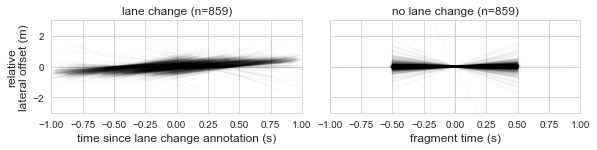

In [206]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1,2,figsize=(8,2),sharey=True)
for fragment_pos in fragments_positive:
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.mean() , alpha=0.02, c='k')#-fragment_pos.offset_pos.loc[abs(fragment_pos.t_fragment).idxmin()]
    axs[0].set_ylim(-3,3)
for fragment_neg in fragments_negative:
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset-fragment_neg.offset.mean() , alpha=0.02, c='k')
    
axs[0].set_xlim(-window_size/2,window_size/2)
axs[1].set_xlim(-window_size/2,window_size/2)
axs[0].set_title(f'lane change (n={len(fragments_positive)})')
axs[1].set_title(f'no lane change (n={len(fragments_negative)})')
plt.tight_layout()

axs[0].set_xlabel('time since lane change annotation (s)', size=12)
axs[1].set_xlabel('fragment time (s)', size=12)
axs[0].set_ylabel('relative\nlateral offset (m)', size=12)
# axs[0].text(-0.2,-2.8,"$t_{LC}$",size=14)
# plt.grid(axis='y')
# axs[0].set_xticklabels(['$-3$','$-2$','$-1$', '$0t_{LC}$', '$1$', '$2$', '$3$'])
plt.savefig('figures/positive_negative_fragments.png', dpi=600, bbox_inches='tight')

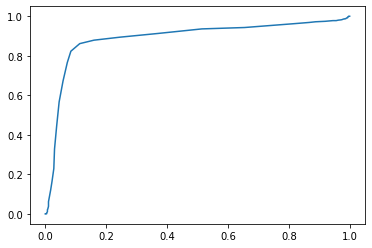

In [96]:
plt.plot(result_df.FPR, result_df.TPR)

In [81]:
len(fragments_positive)

645

In [91]:
fragments_positive[0]

,t,date,lat_gps,lon_gps,alt,speed,speed3D,fix,precision,speed_haversine,...,lon,lat,strategy metric_road,chunk_match_ix_road,order_road,x,y,t_fragment,relative_signal,offset_pos
1,327.050037,2021-06-04 08:07:25.050000+00:00,51.990070,4.391526,-7.615758,26.941,97.200,3.0,130.0,26.881497,...,4.391636,51.989984,0.979971,1,171,86618.63419,445089.8165,-0.496811,0.000000,-4.669011
2,328.043659,2021-06-04 08:07:26.043000+00:00,51.989841,4.391639,-7.664758,26.677,96.156,3.0,130.0,26.455484,...,4.391737,51.989753,0.979971,1,172,86625.21900,445064.0227,0.496811,-0.854715,-3.814296


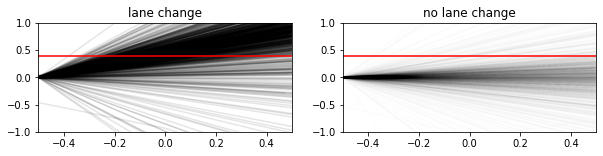

In [114]:
fig,axs=plt.subplots(1,2,figsize=(10,2))
for fragment_pos in fragments_positive: 
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.iloc[0], color='k', alpha=0.1)
for fragment_neg in fragments_negative: 
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset - fragment_neg.offset.iloc[0], color='k', alpha=0.01)

axs[0].set_title('lane change')
axs[0].set_xlim(-0.5,0.5)
axs[0].set_ylim(-1,1)

axs[1].set_xlim(-0.5,0.5)
axs[1].set_ylim(-1,1)


axs[1].set_title('no lane change')

axs[0].axhline(.4, color='red')
axs[1].axhline(.4, color='red')



In [ ]:
a

# plotting

In [9]:
from analysis_helpers import plot_fragments_offset_with_baseline

# select n random fragments for 3-pane plot

random.seed(42)
fragment_dfs_baseline=random.sample(baseline_fragments_alltrips, n_samples=110)



fragments = extract_lanechange_fragments_alltrips(plot_col, trip_dfs, trip_names, lca_dfs, device_nr, sections, window_size)

params = {'ylims': (-4,4),
          'xlims': (-4,4),
         'alpha': 0.05,
         'ylabel': 'relative lateral\ndistance (m)',
         'xlabel': 'time since lane change (s)'}


# plot_fragments_offset(fragments, 'relative_signal', params)
plot_fragments_offset_with_baseline(fragments, fragment_dfs_baseline, 'relative_signal', params)

# in case of velocity measures, use:
# plot_fragments(fragments, plot_col, params)

# plt.savefig('figures/lanechanges_baseline.png', dpi=600, bbox_inches='tight')

TypeError: sample() got an unexpected keyword argument 'n_samples'

In [ ]:
def get_results(fragments_positive, fragments_negative, threshold):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    y_true = []
    y_score = []

    for fragment_pos in fragments_positive:
        y_true.append(1)
        offset_diff = fragment_pos.offset_pos.iloc[-1] - fragment_pos.offset_pos.iloc[0]
        if offset_diff > threshold: #if positive class is assigned:
            TP+=1
            y_score.append(1)
        else:
            FN+=1
            y_score.append(0)

    for fragment_neg in fragments_negative:
        y_true.append(0)
        offset_diff = fragment_neg.offset.iloc[-1] - fragment_neg.offset.iloc[0]
        if offset_diff > threshold: #if positive class is assigned:
            FP+=1
            y_score.append(1)
        else:
            TN +=1
            y_score.append(0)
            
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    return y_true, y_score, TP, FP, TN, FN, accuracy, TPR, FPR

# Plot the lane change in methods figure

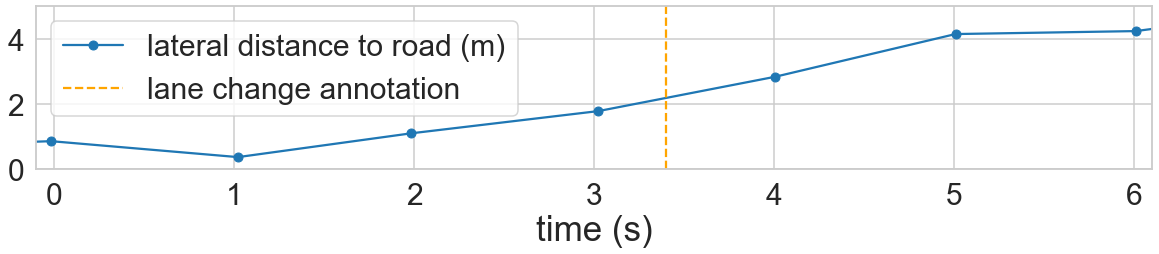

In [195]:
sns.set_style('whitegrid')
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(20,3))
trip_df = trip_dfs[2][1]
fragment = trip_df[trip_df.t.between(1414,1423)]
plt.plot(fragment.t-fragment.t.iloc[0]-1, fragment.offset, marker = 'o', label='lateral distance to road (m)')
ax.set_ylim(0,5)
ax.set_xlim(-.1,6.1)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
ax.set_xlabel('time (s)', size=35)
# ax.set_ylabel('lateral\ndist. (m)', size=35) 
ax.axvline(3.4, c='orange', label = 'lane change annotation', linestyle='--')
ax.legend(prop={'size': 30})

plt.savefig('figures/lateral_dist_methods_with_annotation.png', dpi=60, bbox_inches='tight')

In [120]:
device_names

['GlobalSat', 'GoPro downsampled (last)', 'GoPro', 'P20', 'S9']